# Springboard--DSC Program

# Capstone Project 1 - Statistical Data Analysis 
### by Ellen A. Savoye

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Summary

During EDA, I created new features to convert the target variable into binary as well as created toxicity bins: low, medium, and high. In combination with comment length and word frequency, I visually explored the distribution of binned toxicity for any patterns, trends, or similarities. I found that toxic comments had a tendency for being shorter in length than non-toxic. 

Using statistical analysis, I'm going to see if the average length of comments associated with toxic/non-toxic comments have a statistically significant difference. 

Following that, I am going to create my design matrix and use it to determine which features are correlated and statistically significant via correlation coefficient and p-values.  


# Import packages and data


In [0]:
# !pip install wordcloud
# !pip install kaggle
# !pip install spacy
# !pip install swifter
# !pip install tqdm

In [2]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter

# libraries for NLP
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from scipy import stats
# from scipy.stats import pearsonr

# libraries for getting and moving data
import os
from os import path
import shutil
from zipfile import ZipFile

# for Images
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# google colab only
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
# necessary dependencies for text pre-processing

nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [0]:
# Set directories
# Google Colab
src = "/content/drive/My Drive/DS-Capstone_1/Code/"
dst = "/content/drive/My Drive/DS-Capstone_1/Data/"

# Local computer
# src = "C:\\Users\\ellen\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Code\\"
# dst = "C:\\Users\\ellen\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Data\\"

# Work computer
# src = "C:\\Users\\esavoye\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Code\\"
# dst = "C:\\Users\\esavoye\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Data\\"

# Computer path
# unpickled_df = pd.read_pickle(dst + '/full_data_w_features.pkl')
# unpickled_df_slimmed = pd.read_pickle(dst + '/slimmed_data_w_features.pkl')

# Colab path
unpickled_df = pd.read_pickle(dst + 'full_data_w_features.pkl')
unpickled_df_slimmed = pd.read_pickle(dst + 'slimmed_data_w_features.pkl')


In [8]:
unpickled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 51 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

# Statistical Analysis

## Testing Null Hypothesis


Given that the libraries and data files are loaded, I'm now going to see if the average length of comments associated with toxic/non-toxic comments have a statistically significant difference. 

My null hypothesis is the average length of toxic comments and average length of non-toxic comments are the same.

My alternative hypothesis is that there is a variation between the averages of toxic and non-toxic comments.

I'll be using a 5% significance level (𝛼=0.05) and a bootstrapped hypothesis to calculate the p-value of the observed difference between toxic and non-toxic comment lenghts. 

In [0]:
# testing with n=5,000
N_rep = 5000

# bootstrap replicate function
def bs_replicate_1d(data, func):
    '''Generate bootstrap replicate of 1D data'''
    bs_sample = np.random.choice(data, len(data))
    
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bs_replicate_1d(data, func)

    return bs_replicates


In [10]:
bs_replicates = [bs_replicate_1d(unpickled_df.comment_len, np.mean) for i in np.arange(N_rep)]

conf_int = np.percentile(bs_replicates, [5,95])
print(conf_int)

[284.88419735 285.53095629]


In [0]:
# create data sets to test hypothesis

toxic_com = unpickled_df[unpickled_df.target_binary == 1].comment_len
non_toxic_com = unpickled_df[unpickled_df.target_binary == 0].comment_len

In [12]:
# difference of means

diff_of_means = np.mean(non_toxic_com) - np.mean(toxic_com)
print(diff_of_means)

20.71298975683942


In [13]:
# Two-sample bootstrap hypothesis test for difference of means

# Compute mean of all comment lengths
comment_len_mean = np.mean(unpickled_df.comment_len)

# Generate shifted arrays
toxic_com_shifted = toxic_com - np.mean(toxic_com) + comment_len_mean
non_toxic_com_shifted = non_toxic_com - np.mean(non_toxic_com) + comment_len_mean

# Compute 5,000 bootstrap replicates from shifted arrays
bs_replicates_toxic_com = draw_bs_reps(toxic_com_shifted, np.mean, size=N_rep)
bs_replicates_non_toxic_com = draw_bs_reps(non_toxic_com_shifted, np.mean, size=N_rep)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_non_toxic_com - bs_replicates_toxic_com

# Compute and print p-value: p
p = np.sum(bs_replicates >= diff_of_means) / len(bs_replicates)
print('p-value =', p)

p-value = 0.0


The p-value calculated is 0.0. Strictly speaking, this is statistically significant. However, one thing to keep in mind is the larger the data set, the easier it is to get a low p-value. In terms of practical significance and practical considerations, yes it is important. Knowing that the average length of comments is different between toxic and non-toxic comments has practical significance in that it lends a certain context. I was originally under the impression that toxic comments were going to be long-winded and longer in length. Between EDA and testing my null hypothesis, I was shown to be incorrect.  

So in the end, I reject my null hypothesis. 

In [0]:
# create data sets to test hypothesis

toxic_com = unpickled_df_slimmed[unpickled_df_slimmed.target_binary == 1].comment_len
non_toxic_com = unpickled_df_slimmed[unpickled_df_slimmed.target_binary == 0].comment_len

In [14]:
# difference of means

diff_of_means = np.mean(non_toxic_com) - np.mean(toxic_com)
print(diff_of_means)

20.71298975683942


In [15]:
# Two-sample bootstrap hypothesis test for difference of means

# Compute mean of all comment lengths
comment_len_mean = np.mean(unpickled_df.comment_len)

# Generate shifted arrays
toxic_com_shifted = toxic_com - np.mean(toxic_com) + comment_len_mean
non_toxic_com_shifted = non_toxic_com - np.mean(non_toxic_com) + comment_len_mean

# Compute 5,000 bootstrap replicates from shifted arrays
bs_replicates_toxic_com = draw_bs_reps(toxic_com_shifted, np.mean, size=N_rep)
bs_replicates_non_toxic_com = draw_bs_reps(non_toxic_com_shifted, np.mean, size=N_rep)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_non_toxic_com - bs_replicates_toxic_com

# Compute and print p-value: p
p = np.sum(bs_replicates >= diff_of_means) / len(bs_replicates)
print('p-value =', p)

p-value = 0.0


I ran the same bootstrap test on the subset comprised of the identity labels and found the same result as above.

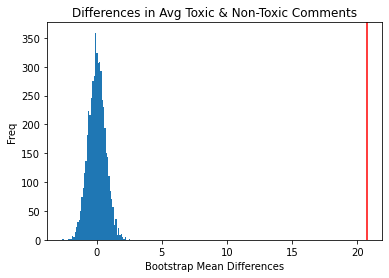

In [16]:
_ = plt.hist(bs_replicates, bins=50)
_ = plt.axvline(x=diff_of_means, color='r')
_ = plt.xlabel('Bootstrap Mean Differences')
_ = plt.ylabel('Freq')
_ = plt.title('Differences in Avg Toxic & Non-Toxic Comments')

## Correlation Between Features

In [0]:
def pearsonr_pval(x,y):
    return stats.pearsonr(x,y)[1]

In [0]:
subset_col = ['male', 'female', 'transgender', 'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation',
  'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity',
  'physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability', 'target_binary'] 

In [0]:
identity_subset_df = unpickled_df_slimmed[subset_col].copy()

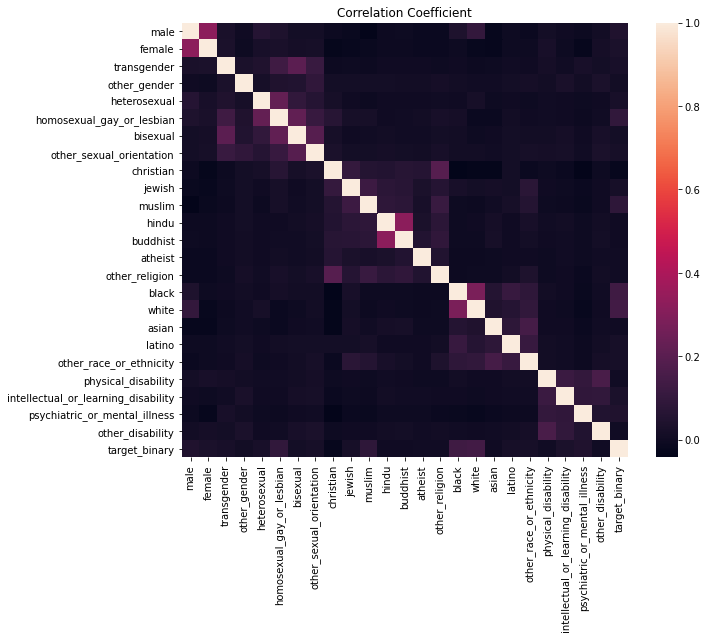

In [28]:
# correlation coefficients
plt.figure(figsize=(10,8))
ax = plt.axes()
ax.set_title('Correlation Coefficient')
sns.heatmap(identity_subset_df.corr(),annot=False,  ax = ax)

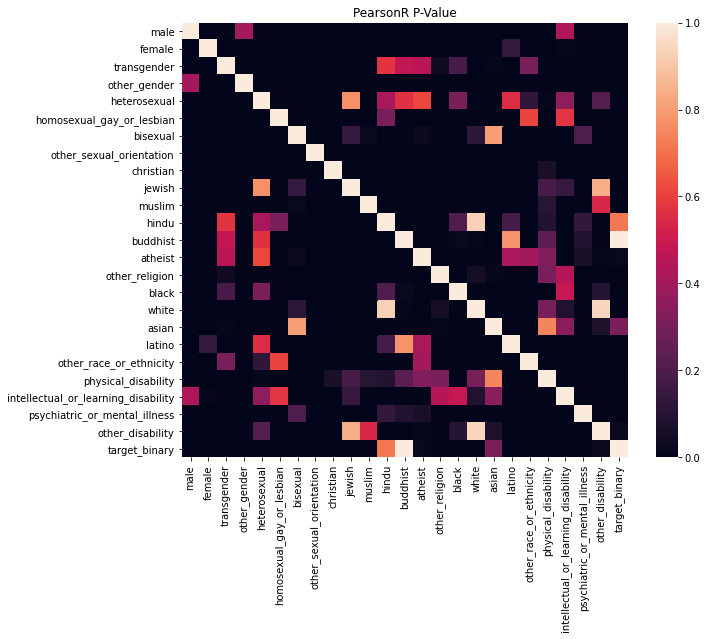

In [29]:
# p-values

plt.figure(figsize=(10,8))
ax = plt.axes()
ax.set_title('PearsonR P-Value')
sns.heatmap(identity_subset_df.corr(method=pearsonr_pval),annot=False,  ax = ax)

## Help???

Prior to creating the correlation and p-values between features, I first need to assemble my design matrix using my slimmed data set.

In [17]:
def make_xy(unpickled_df_slimmed, vectorizer=None):
    if vectorizer is None:
        print('The value of vectorizer is None ... using CountVectorizer')
    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(unpickled_df_slimmed.clean_text)
    # X = X.tocsc()  # some versions of sklearn return COO format
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X)
    y = (unpickled_df_slimmed.target_binary == 1).values.astype(np.int)
    return X, y, vectorizer 
#

X, y, vectorizer = make_xy(unpickled_df_slimmed)

The value of vectorizer is None ... using CountVectorizer


In [77]:
print('X is a ' + str(type(X)))

X is a <class 'scipy.sparse.csr.csr_matrix'>


In [0]:
X.sparse.to_dense()

In [1]:
sns.heatmap(X.corr(),cmap='Blues',annot=False) 

NameError: ignored

# Output

No new features or transformations were done on the original data or slimmed data so I will not be saving out any pickled data files.

In [0]:
# Create pickle file for use in the future 

# unpickled_df_slimmed.to_pickle(dst + '/slimmed_data_w_features.pkl')
# unpickled_df.to_pickle(dst + '/full_data_w_features.pkl')